In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
import scipy.misc
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import pretrainedmodels

seed = 0
np.random.seed(seed)
torch.manual_seed(seed);

In [2]:
device = torch.device('cuda')

In [3]:
train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.RandomVerticalFlip())
transforms.RandomRotation(180, expand=True)
train_transform.transforms.append(transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(1.0,1.0)))
train_transform.transforms.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0))
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(transforms.Normalize([0.4373, 0.4434, 0.4725],[0.1201, 0.1231, 0.1052]))
train_transform.transforms.append(transforms.RandomErasing())

In [29]:
test_transform = transforms.Compose([])
test_transform.transforms.append(transforms.RandomResizedCrop(224, scale=(1.0, 1.0), ratio=(1.0,1.0)))
test_transform.transforms.append(transforms.ToTensor())
test_transform.transforms.append(transforms.Normalize([0.4373, 0.4434, 0.4725],[0.1201, 0.1231, 0.1052]))

In [5]:
class image_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        image_name = self.df.iloc[idx]['image']
        image_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/classification/images_preprocessed/'\
        + image_name + '.jpg'
        image = Image.open(image_path)
        
        if self.train:
            image_tensor = train_transform(image)
        else:
            image_tensor = test_transform(image)
            
        metadata = self.df.loc[idx][['sex_index','age_index','anterior torso', 'head/neck', 'lateral torso',\
                                     'lower extremity','oral/genital', 'palms/soles', 'posterior torso',\
                                     'upper extremity']].values.astype('float')
        metadata = torch.tensor(metadata, dtype=torch.float)
        label = self.df.loc[idx][['MEL','NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC','UNK']].values.astype('float')
        label = torch.tensor(label, dtype=torch.float)
        label = label.data.max(-1)[1]
        sample = {'x1': image_tensor, 'x2':metadata,'y': label}
        
        return sample

In [6]:
train_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/train.csv'
val_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/val.csv'
test_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/test.csv'
BATCH_SIZE = 8
train_loader = DataLoader(image_dataset(train_df_path,train = True), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(image_dataset(val_df_path), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(image_dataset(test_df_path), batch_size=BATCH_SIZE, shuffle=True)

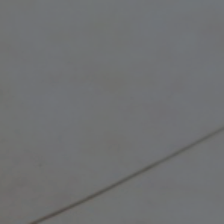

In [7]:
image_tensor = next(iter(train_loader))['x1'][0]
inv_normalize = transforms.Normalize(mean=[-0.4373/0.1201, -0.4434/0.1231, -0.4725/0.1052],\
                                     std=[1/0.1201, 1/0.1231, 1/0.1052])
image = inv_normalize(image_tensor)
transforms.ToPILImage()(image)

In [8]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [9]:
model_name = 'se_resnet152'
se_resnet152 = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

In [10]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn = se_resnet152
      
        self.fc = nn.Linear(1000, 9)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        #x2 = F.relu(self.fc2(data))
        #x = torch.cat((x1, x2), dim=1)       
        x = self.fc(x1)
        
        return x

In [11]:
sample = next(iter(train_loader))
image = sample['x1'].to('cpu')
data = sample['x2'].to('cpu')
model = MyModel().to('cpu')
output = model(image,data)

In [12]:
output.shape

torch.Size([8, 9])

In [13]:
def train(model, train_loader=train_loader, val_loader=val_loader, learning_rate=5e-5, num_epoch=100):
    start_time = time.time()
    
    distribution = torch.FloatTensor([0.17652477, 0.50707283, 0.13323245, 0.03348905, \
                                  0.10494111, 0.00894796, 0.00986907, 0.02592276, 0.]).to(device)
    loss_fn = nn.CrossEntropyLoss(weight=distribution)
    optimizer = optim.Adam(model.parameters(),lr=learning_rate)
    
    train_loss_return = []
    train_acc_return = []
    val_loss_return = []
    val_acc_return = []
    best_acc = 0
    
    for epoch in range(num_epoch):
        # Training steps
        correct = 0
        total = 0
        predictions = []
        truths = []
        model.train()
        train_loss_list = []
        for i, (sample) in enumerate(train_loader):
            image = sample['x1'].to(device)
            data = sample['x2'].to(device)
            labels = sample['y'].to(device)
            outputs = model(image,data)
            pred = outputs.data.max(-1)[1]
            predictions += list(pred.cpu().numpy())
            truths += list(labels.cpu().numpy())
            total += labels.size(0)
            correct += (pred == labels).sum()
            model.zero_grad()
            loss = loss_fn(outputs, labels)
            train_loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
        # report performance
        acc = (100 * correct / total)
        train_acc_return.append(acc)
        train_loss_every_epoch = np.average(train_loss_list)
        train_loss_return.append(train_loss_every_epoch)
        print('----------Epoch{:2d}/{:2d}----------'.format(epoch+1,num_epoch))
        print('Train set | Loss: {:6.4f} | Accuracy: {:4.2f}% '.format(train_loss_every_epoch, acc))
        
        # Evaluate after every epochh
        correct = 0
        total = 0
        model.eval()
        predictions = []
        truths = []
        val_loss_list = []
        with torch.no_grad():
            for i, (sample) in enumerate(val_loader):
                image = sample['x1'].to(device)
                data = sample['x2'].to(device)
                labels = sample['y'].to(device)
                outputs = model(image,data)
                loss = loss_fn(outputs, labels)
                val_loss_list.append(loss.item())
                pred = outputs.data.max(-1)[1]
                predictions += list(pred.cpu().numpy())
                truths += list(labels.cpu().numpy())
                total += labels.size(0)
                correct += (pred == labels).sum()
            # report performance
            acc = (100 * correct / total)
            val_acc_return.append(acc)
            val_loss_every_epoch = np.average(val_loss_list)
            val_loss_return.append(val_loss_every_epoch)
            if acc > best_acc:
                best_acc = acc
                best_model_wts = model.state_dict()
            save_model(model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts)
            elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
            print('Test set | Loss: {:6.4f} | Accuracy: {:4.2f}% | time elapse: {:>9}'\
                  .format(val_loss_every_epoch, acc,elapse))
    return model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts

def save_model(model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts):
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_acc':train_acc_return,\
             'val_loss':val_loss_return, 'val_acc':val_acc_return}
    torch.save(state, 'checkpoint_Model_seresnet152.pt')
    return None

In [14]:
model = MyModel().to(device)

In [15]:
#train(model)

## Evaluate

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp
import warnings
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
warnings.filterwarnings('ignore')

In [31]:
path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/py files/SeReNet152/checkpoint_Model_resenet152.pt'
model.load_state_dict(torch.load(path)['best_model_wts'])


<All keys matched successfully>

In [32]:
BATCH_SIZE = 8
test_loader = DataLoader(image_dataset(test_df_path), batch_size=BATCH_SIZE, shuffle=False)

In [33]:
def evaluate_model(model, dataloader):   
    model.eval()
    y_test_label = []
    y_test = []
    y_score = []
    pre = []
    for i, (sample) in enumerate(dataloader):
        image = sample['x1'].to(device,dtype=torch.float)
        data = sample['x2'].to(device)
        label = sample['y'].to('cpu')
        y_test_label = y_test_label+label.tolist()
        label = label_binarize(label, classes=[0,1,2,3,4,5,6,7,8])
        if y_test == []:
            y_test=label
        else:
            y_test = np.concatenate((y_test,label),axis = 0)
        output = model(image,data)
        output = F.softmax(output,dim=1)
        output = output.to('cpu')
        if y_score == []:
            y_score=np.array(output.detach().numpy())
        else:
            y_score = np.concatenate((y_score,output.detach().numpy()),axis = 0)
    for i in y_score:
        pre.append(list(i).index(max(i)))
    return y_test_label,y_test,pre,y_score

In [34]:
y_test_label,y_test,pre,y_score = evaluate_model(model,test_loader)

In [35]:
def ROC_curve(y_test,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    lw = 2
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return fpr,tpr,roc_auc

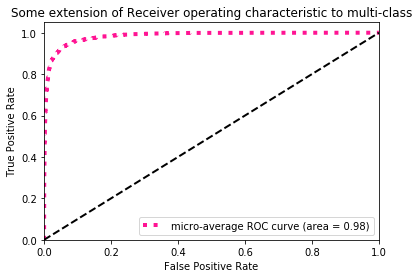

In [36]:
fpr,tpr,roc_auc = ROC_curve(y_test,y_score);

In [37]:
roc_auc

{0: 0.9381274598571729,
 1: 0.967391188992796,
 2: 0.9881526776254581,
 3: 0.9617488367488367,
 4: 0.9584167620137299,
 5: 0.9678126303949492,
 6: 0.9968411715723544,
 7: 0.9710763339844356,
 8: nan,
 'micro': 0.9842119114541584,
 'macro': nan}

In [38]:
print(classification_report(y_test_label, pre))

              precision    recall  f1-score   support

           0       0.79      0.74      0.77       937
           1       0.89      0.95      0.92      2626
           2       0.82      0.89      0.85       612
           3       0.84      0.41      0.55       182
           4       0.73      0.77      0.75       506
           5       1.00      0.33      0.49        55
           6       0.94      0.66      0.77        44
           7       0.73      0.46      0.56       104

    accuracy                           0.85      5066
   macro avg       0.84      0.65      0.71      5066
weighted avg       0.84      0.85      0.84      5066



In [39]:
balanced_accuracy_score(y_test_label, pre)

0.6499526819117889